## Airbus sheep detection

### Libraries downloading

In [ ]:
#!pip install opencv-python
#!pip install pydot
#!pip install graphviz
#!pip install segmentation-models

In [ ]:
import pandas as pd

import zipfile

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import shutil
import cv2
import pydot
import graphviz

from sklearn.model_selection import train_test_split

import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold

### Data analys

In [ ]:
# Roots with data
data_dir = 'C:/Users/chugu/.kaggle/Carnava cars segmentation'
train_raw_data = data_dir+'/train'
#test_raw_data = data_dir + '/airbus_test/Airbus_test_raw'

segmentations = pd.read_csv(data_dir+'/train_masks.csv')
#test_segmentations = pd.read_csv(data_dir+'/sample_submission_v2.csv')
display(segmentations.head())
print(segmentations.shape)


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


(5088, 2)


### Data preparation

#### Splitting data

In [ ]:
cars_train = segmentations[:2000]
cars_val = segmentations[2000:2800]
cars_test = segmentations[2800:3200]

#### Image preprocessing

In [ ]:
def rle_decode(mask_rle, shape=(768, 768, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

(768, 768)


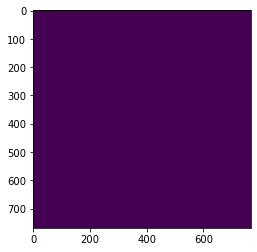

In [ ]:
img_name, mask_rle = cars_train.iloc[5]
img = cv2.imread(train_raw_data+'/{}'.format(img_name))
mask = rle_decode(mask_rle)
print(mask.shape)
plt.imshow(mask)

In [ ]:
def rle2mask(rle, imgshape):
  if rle != 0:
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros(width * height).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start + lengths[index])] = 1
        current_position += lengths[index]
  else:
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros(width * height).astype(np.uint8)
        
  return np.flipud(np.rot90(mask.reshape(height,width), k = 1))

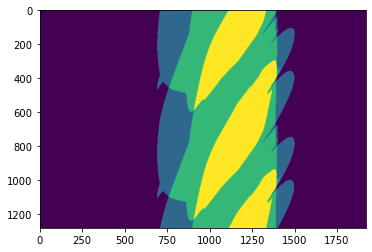

In [ ]:
img_name, mask_rle = cars_train.iloc[i]
img = cv2.imread(train_raw_data+'/{}'.format(img_name))
mask = rle2mask(mask_rle, img.shape)
mask.shape
plt.imshow(mask)

In [ ]:
def rle_decode(mask_rle, shape=(1280, 1918)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [ ]:
img_name, mask_rle = cars_train.iloc[i]
mask = rle_decode(mask_rle)
mask.shape

(1280, 1918)

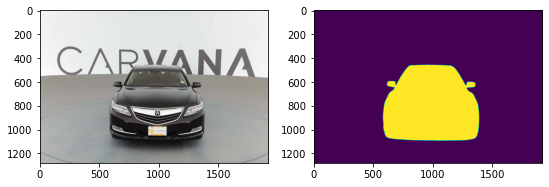

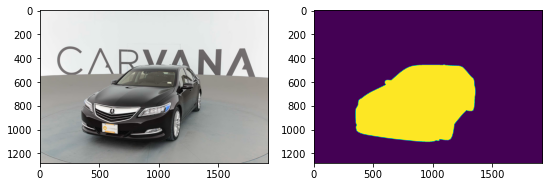

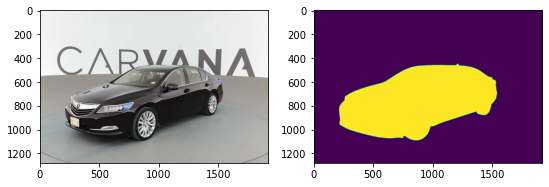

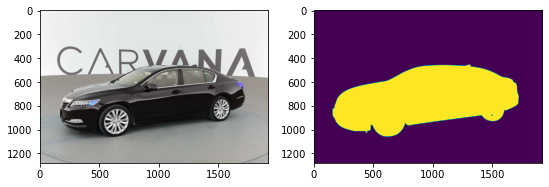

In [ ]:
for i in range(4):
  img_name, mask_rle = cars_train.iloc[i]

  img = cv2.imread(train_raw_data+'/{}'.format(img_name))
  mask = rle_decode(mask_rle)
  #print(img.shape)
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
  axes[0].imshow(img)
  axes[1].imshow(mask)

  plt.show()

In [ ]:
img_name, mask_rle = cars_train.iloc[3]
print('Shape of image ', (cv2.imread(train_raw_data+'/{}'.format(img_name))).shape)
print('Shape of mask ', (rle_decode(mask_rle)).shape)

Shape of image  (1280, 1918, 3)
Shape of mask  (1280, 1918)


#### Generator

In [ ]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread(train_raw_data+'/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch).astype(np.float32)

        yield x_batch, np.expand_dims(y_batch, -1)

In [ ]:
#testing the work of generator
for x, y in keras_generator(cars_train, 16):
    break

print('Image shape: ', x.shape)
print('Mask shape: ', y.shape)  

Image shape:  (16, 256, 256, 3)
Mask shape:  (16, 256, 256, 1)


In [ ]:
print(np.amax(x), np.amin(x))
print(np.amax(y), np.amin(y))

1.0 0.0
1.0 0.0


### Network creation

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)

# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)    

In [ ]:
print(dice_coef(x[1], x[1]))

tf.Tensor(0.7945654990439112, shape=(), dtype=float64)


FCN

In [ ]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation


base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)


base_out = base_model.output


up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(1, (1, 1))(up)
conv = Activation('sigmoid')(conv)

model = Model(inputs=base_model.input, outputs=conv)

In [ ]:
callbacks = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0)

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(adam, loss=IoU_loss, metrics=[IoU, 'binary_crossentropy'])

In [ ]:
batch_size = 4
model.fit(keras_generator(cars_train, batch_size),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(cars_val, batch_size),
              validation_steps=20)

Epoch 1/3
 14/100 [===>..........................] - ETA: 11:41 - loss: 0.6179 - IoU: 0.3821 - binary_crossentropy: 0.6643

KeyboardInterrupt: ignored

In [ ]:
for x_test, y_test in keras_generator(cars_test, 5):
    break

print('Image shape: ', x_test.shape)
print('Mask shape: ', y_test.shape)   

Image shape:  (5, 256, 256, 3)
Mask shape:  (5, 256, 256, 1)


In [ ]:
pred = model.predict(x_test)

(5, 256, 256, 1)
Max and min values:  1.0  4.663981e-26


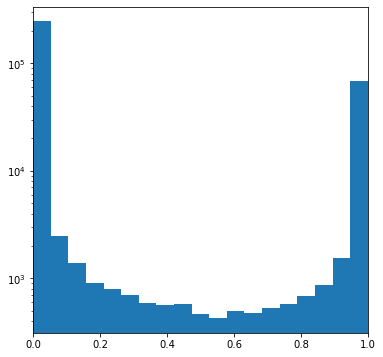

In [ ]:
print(pred.shape)
print('Max and min values: ', np.amax(pred), '', np.amin(pred))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

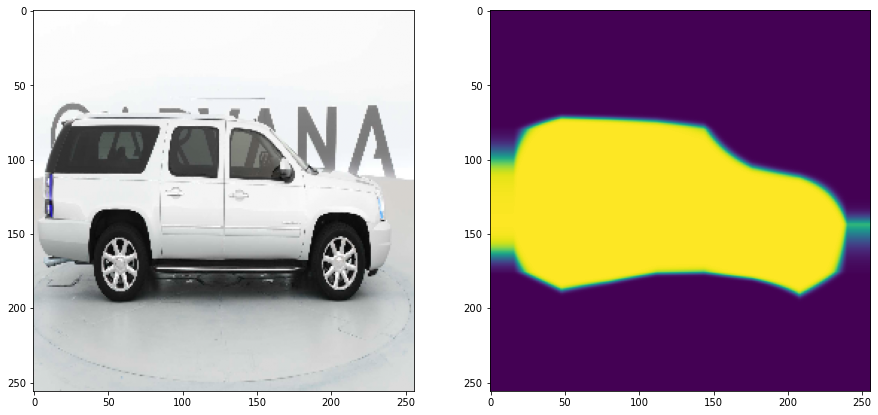

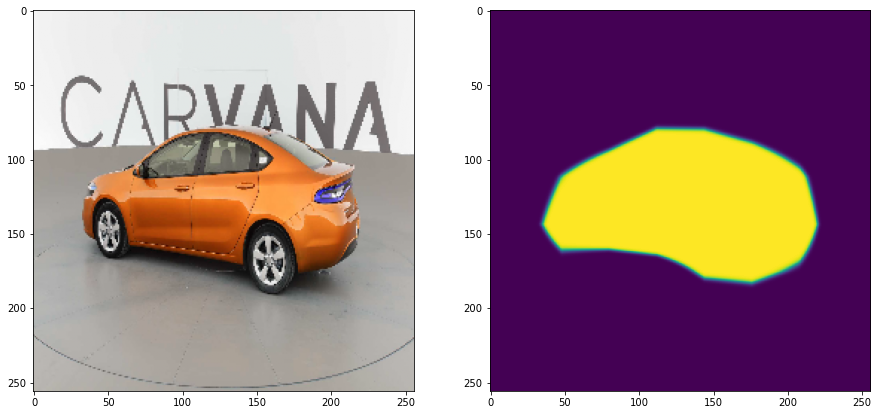

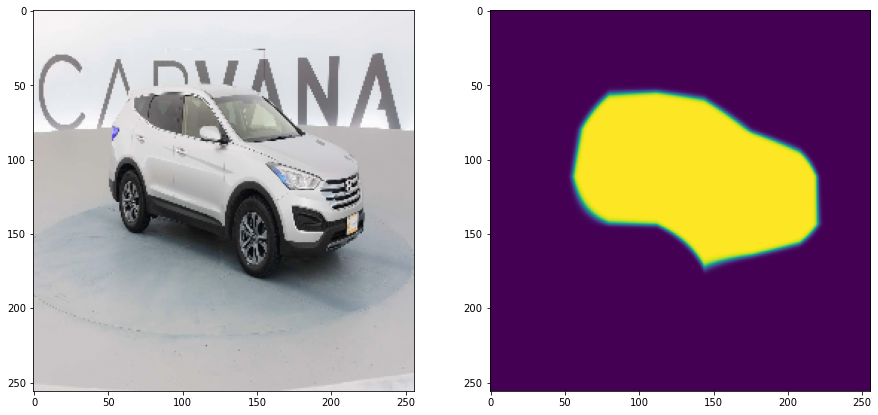

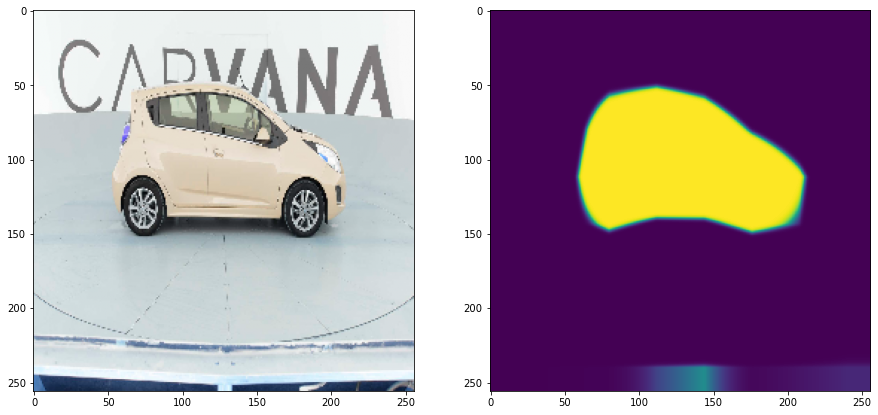

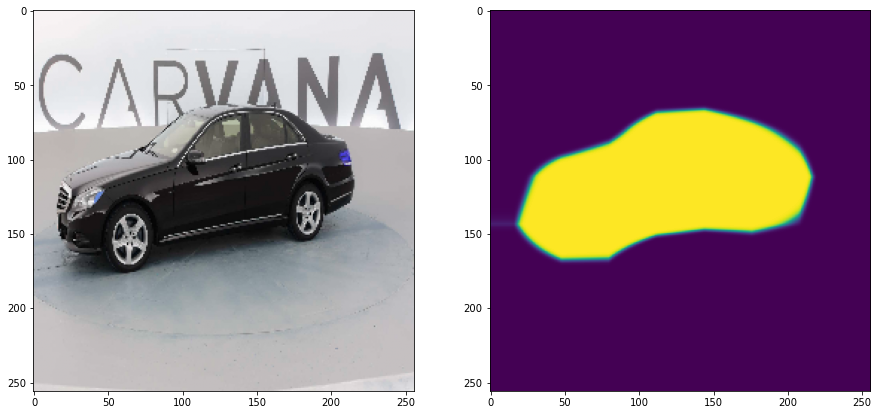

In [ ]:
for i in range(5):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
  axes[0].imshow(x_test[i])
  axes[1].imshow(pred[i, ..., 0])

  plt.show()

#### U-net

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

callback = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0)

adam = keras.optimizers.Adam()

reduceLROnPlat = ReduceLROnPlateau(monitor=IoU_loss, factor=0.5, 
                                   patience=1, 
                                   verbose=1, mode='max', cooldown=2, min_lr=1e-6)

callbacks = [callback, reduceLROnPlat]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(adam, loss='binary_crossentropy', metrics=[IoU])

In [ ]:
batch_size = 4
model.fit(keras_generator(cars_train, batch_size),
              steps_per_epoch=100,
              epochs=4,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(cars_val, batch_size),
              validation_steps=20)

Epoch 1/4
100/100 [==============================] - 487s 5s/step - loss: 0.1925 - IoU: 0.6859 - val_loss: 0.1030 - val_IoU: 0.7060
Epoch 2/4
 82/100 [=======================>......] - ETA: 1:24 - loss: 0.0908 - IoU: 0.7637

KeyboardInterrupt: ignored

#### Predictions test

In [ ]:
for x_test, y_test in keras_generator(cars_test, 5):
    break

print('Image shape: ', x_test.shape)
print('Mask shape: ', y_test.shape)   

Image shape:  (5, 256, 256, 3)
Mask shape:  (5, 256, 256, 1)


In [ ]:
pred = model.predict(x_test)

(5, 256, 256, 1)
Max and min values:  0.9999974  4.2490534e-17


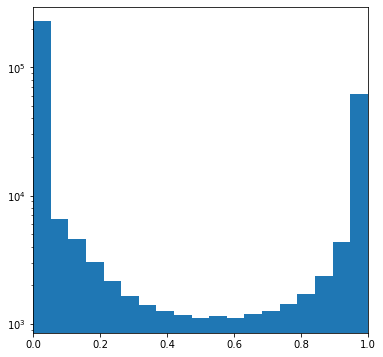

In [ ]:
print(pred.shape)
print('Max and min values: ', np.amax(pred), '', np.amin(pred))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

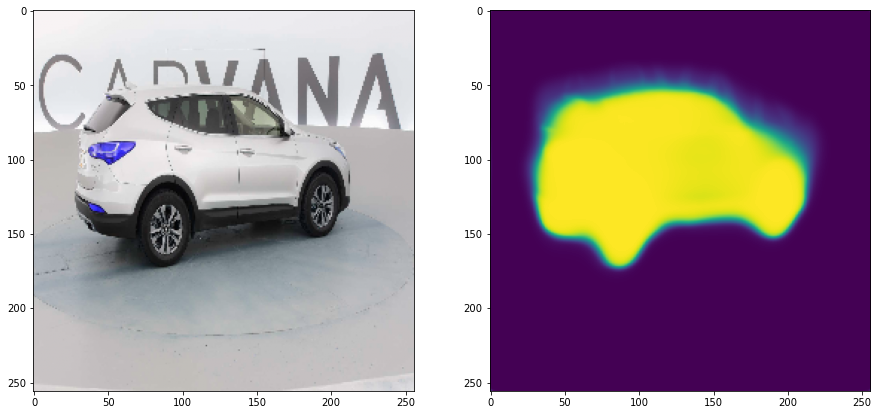

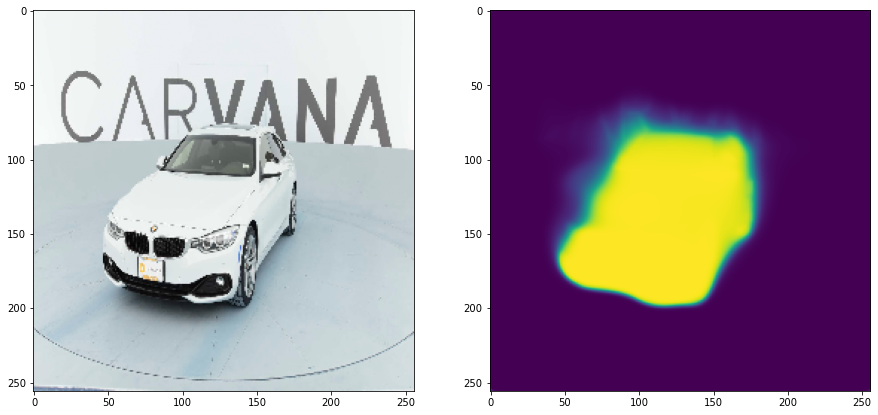

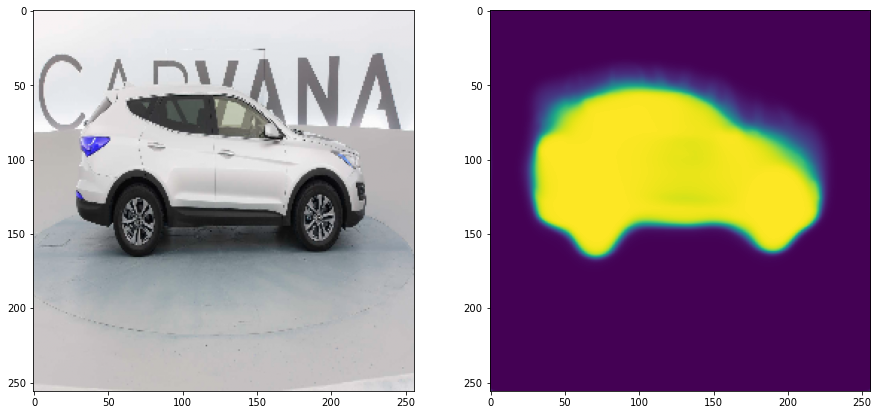

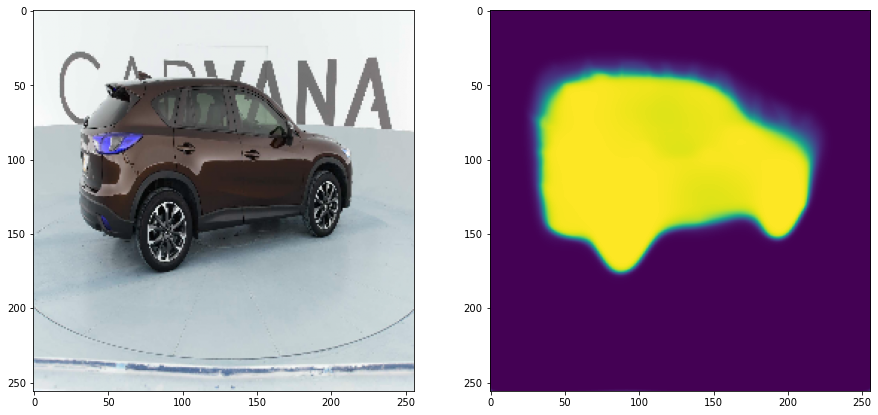

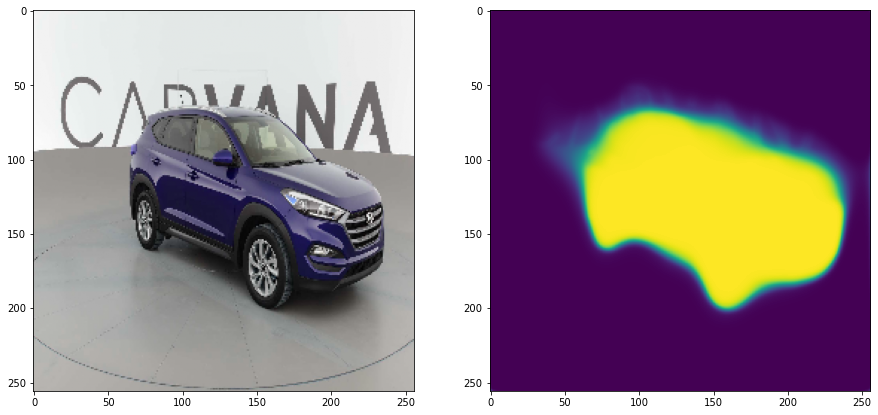

In [ ]:
for i in range(5):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
  axes[0].imshow(x_test[i])
  axes[1].imshow(pred[i, ..., 0])

  plt.show()